In [1]:
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig
from PIL import Image
import requests
import torch
import os
import matplotlib.pyplot as plt
import re

In [2]:
model_name = 'allenai/Molmo-7B-D-0924'

In [3]:
# load the processor
processor = AutoProcessor.from_pretrained(
    model_name,
    trust_remote_code=True,
    torch_dtype='auto',
    device_map='auto'
)

In [4]:
# load the model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    #torch_dtype='auto',
    torch_dtype=torch.float16,
    device_map='auto'
)


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
def extract_tasks_and_images(path_to_directory):
    tasks = []
    images = []

    for experiment in os.listdir(path_to_directory):
        if experiment.startswith("."):
            continue
        subdir_path = os.path.join(path_to_directory, experiment)
        task_file_path = os.path.join(subdir_path, "lang.txt")

        # Get Task
        with open(task_file_path, "r") as lang_file:
            task = lang_file.read()
            tasks.append(task)

        # Get image
        for file in os.listdir(subdir_path):
                    if file.startswith("im_") and file.endswith((".png", ".jpg", ".jpeg")):
                        image_path = os.path.join(subdir_path, file)
                        image = Image.open(image_path)
                        images.append(image)

    return tasks, images        

In [6]:
def extract_objects_from_model_output(model_output):
    #Find pattern: (object-name, (x, y))
    pattern = r'\(([^,]+),\s*\((\d+\.?\d*),\s*(\d+\.?\d*)\)\)'
    matches = re.findall(pattern, model_output)
    
    objects = []
    for obj, x, y in matches:
        objects.append((obj.strip(), int(float(x)), int(float(y))))
    return objects


def scale_coordinates(coordinates, image_width, image_height):
    scaled_objects = []
    for obj, x, y in coordinates:
        # Scale coordinates to the image size
        scaled_x = x / 100 * image_width
        scaled_y = y / 100 * image_height
        scaled_objects.append((obj, int(scaled_x), int(scaled_y)))
    return scaled_objects

In [14]:
def visualize_points_on_image(image, labels, sets_of_objects):
    plt.imshow(image, alpha=0.5)
    image_width, image_height = image.size


    for i, objects in enumerate(sets_of_objects):
        scaled_objects = scale_coordinates(objects, image_width, image_height)
    
        # Extract and plot the points
        x_coords = [coord[1] for coord in scaled_objects]
        y_coords = [coord[2] for coord in scaled_objects]
        plt.scatter(x_coords, y_coords, marker='o', label=labels[i])
        #TODO - Verschiedene Sets - Verschiedene marker 
    
        # Annotate each point with its object name
        for obj, x, y in scaled_objects:
            plt.text(x, y, obj, color='black', fontsize=9, ha='right', va='bottom')
    
    # Add labels and show the plot
    plt.title("Coordinates on Image")
    plt.legend(loc="lower right")
    plt.axis("on")  # Show axes
    plt.show()
    plt.close()

In [32]:
prompt_start = "You are the robot in the picture. Your task is to: "

prompts = []
prompt_1 = "First, create a plan how to execute the task. Afterwards, find the relevant objects from your plan in the picture and point to them as well as the robot arm, if that is in the picture."
prompt_2 = "To complete this taks, First create a plan to execute the task. Afterwards find the relevant objects for the task. Then point to the relevant objects in the picture, as well as the robot arm if that is in the picture."
#prompt_3 = "To complete this taks, first find the relevant objects from the task. Reason, why you need them to complete the task. Then pinpoint the relevant objects in the picture, as well as the robot arm."
#prompt_4 = "To complete this task, first find the relevant objects in the picture. Afterwards create a plan to execute the task."
#prompt_4 = "Find objects, that are not relevant for completing this task."

prompts = [prompt_1, prompt_2]
#prompts = [prompt_1, prompt_2, prompt_3, prompt_4]
prompt_end = " Your output format should be like this: (name of object 1, (x1, y1)), (name of object 2, (x2, y2)), ..., with x and y beeing integer values. Dont output anything else."

#prompt_1 = "You are the robot in the picture. Your task is to: put cup from counter or drying rack into sink. Find the relevant objects for that in the picture and output the coordinates of these objects."

In [27]:
temperatures = [0.3, 0.4, 0.6, 0.7]

In [28]:
def do_inference_on_image(image, task, prompt, temperature=0.2):
    # Process inputs
    inputs = processor.process(
        images=image,
        text=prompt_start + task + prompt + prompt_end
    )
    inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

    # generate output
    with torch.autocast(device_type="cuda", enabled=True, dtype=torch.bfloat16):
      output = model.generate_from_batch(
          inputs,
          GenerationConfig(max_new_tokens=200, stop_strings="<|endoftext|>", temperature=temperature, do_sample=True),
          tokenizer=processor.tokenizer
      )
    generated_tokens = output[0,inputs['input_ids'].size(1):]
    generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

    return generated_text
    
    

Task: 1
Task: Move the can from the top left of the burner to the bottom left of the burner
confidence: 0.8

Different Prompts:
Prompt: 1 - Output:  (can, (26.7, 26.7)), (burner, (40.4, 53.8)), (robot arm, (66.2, 15.0)), (spatula, (47.6, 40.4)), (pot, (71.1, 48.6))
Prompt: 2 - Output:  (can, (26.8, 26.4)), (burner, (43.0, 54.1)), (robot arm, (66.4, 15.3))


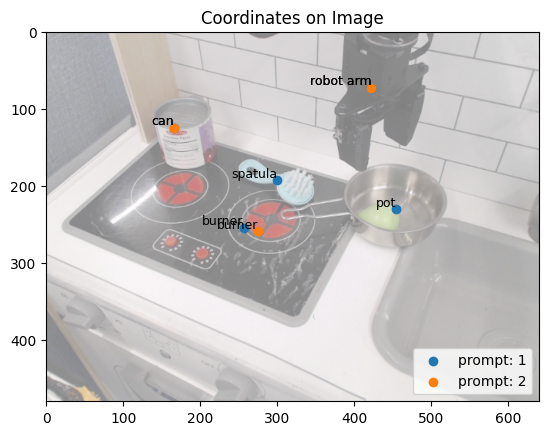



Multiple runs:
Run: 1 - Output:  (can, (28.0, 27.2)), (burner, (40.9, 53.4)), (robot arm, (67.0, 16.8)), (spatula, (46.3, 38.6)), (pot, (70.0, 49.0))
Run: 2 - Output:  (can, (26.8, 25.7)), (burner, (40.4, 51.3)), (robot arm, (65.2, 17.1)), (spatula, (46.1, 38.7)), (pot, (71.0, 47.8))
Run: 3 - Output:  (can, (27.5, 26.8)), (burner, (40.0, 52.8)), (robot arm, (66.1, 15.8)), (spatula, (50.2, 40.0)), (pot, (72.3, 48.2))


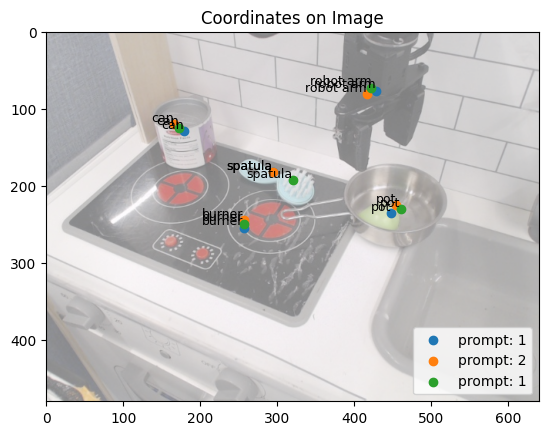



Testing different Temperatures:
Temperature: 0.3 - Output:  (can, (26.3, 27.8)), (burner, (40.8, 57.4)), (robot arm, (66.4, 18.0))
Temperature: 0.4 - Output:  (can, (26.2, 27.5)), (burner, (40.5, 51.0)), (robot arm, (67.1, 21.3))
Temperature: 0.6 - Output:  (can, (27.7, 25.8)), (burner, (44.3, 44.3)), (robot arm, (68.6, 18.1))
Temperature: 0.7 - Output:  (can, (26, 23)), (stove burner, (29, 43)), (robot arm, (62.7, 20.5))


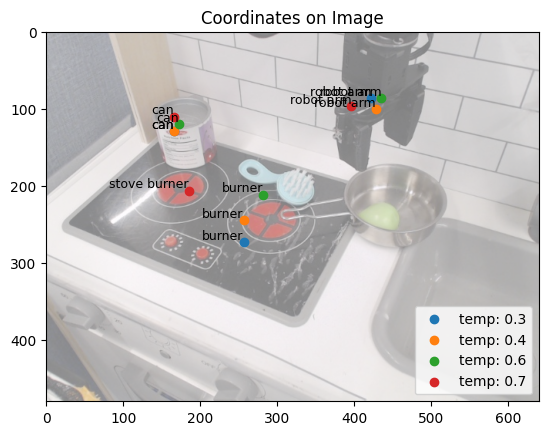



Task: 2
Task: pick up red srewdriver

Different Prompts:
Prompt: 1 - Output:  (red screwdriver, (40, 37)), (robot arm, (65, 15)), (red toolbox, (50, 20)), (white floor, (15, 80)), (wrench, (90, 85))
Prompt: 2 - Output:  (red screwdriver, (35, 36)), (robot arm, (67.9, 10.8)), (red toolbox, (51.0, 15.0))


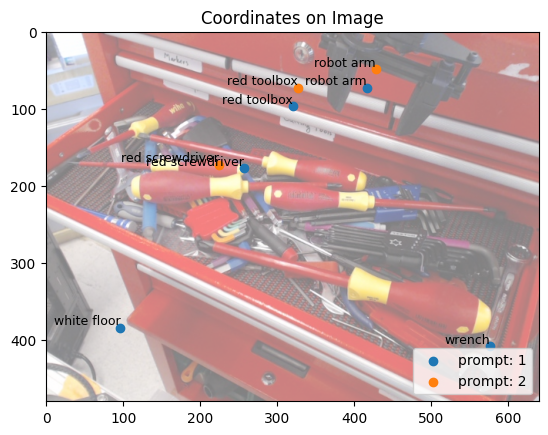



Multiple runs:
Run: 1 - Output:  (red screwdriver, (40, 36)), (red screwdriver, (41, 40)), (red screwdriver, (46, 34)), (red screwdriver, (50, 38)), (red screwdriver, (52, 42)), (red screwdriver, (54, 45)), (red screwdriver, (55, 40)), (red screwdriver, (56, 43)), (red screwdriver, (57, 46)), (red screwdriver, (58, 41)), (red screwdriver, (60, 44)), (red screwdriver, (61, 42)), (red screwdriver, (61, 47)), (red screwdriver, (62, 45)), (red screwdriver, (63, 43)), (red screwdriver,
Run: 2 - Output:  (red screwdriver, (34.1, 38.8)), (red screwdriver, (34.6, 34.5)), (red screwdriver, (77.7, 74.4)), (robot arm, (70.4, 11.6))
Run: 3 - Output:  (red screwdriver, (35.2, 37.5)), (red screwdriver, (40.7, 40.7)), (robot arm, (70.2, 14.0))


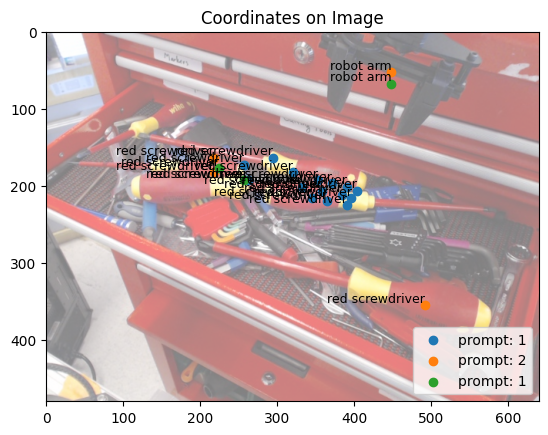



Testing different Temperatures:
Temperature: 0.3 - Output:  (red screwdriver, (41.7, 34.2)), (red screwdriver, (48.9, 43.0)), (red screwdriver, (52.3, 36.5)), (red screwdriver, (72.9, 72.9)), (robot arm, (69.8, 15.9))
Temperature: 0.4 - Output:  (red screwdriver, (38.7, 34.8)), (robot arm, (71.7, 14.4))
Temperature: 0.6 - Output:  (screwdriver, (45, 39)), (robot arm, (67.8, 11.8)), (drawer, (49.0, 28.8)), (red toolbox, (86.9, 18.0))
Temperature: 0.7 - Output:  (red screwdriver, (38.4, 39.5)), (red screwdriver, (66.1, 71.6)), (robot arm, (78.6, 15.3))


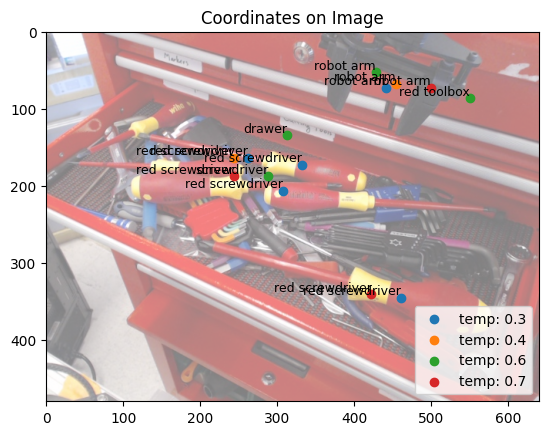



Task: 3
Task: take the eggplant and put it between the two right burners
confidence: 0.6

Different Prompts:
Prompt: 1 - Output:  (eggplant, (51.4, 44.8)), (robot arm, (57.7, 23.7)), (orange bowl, (60.8, 48.7))
Prompt: 2 - Output:  (eggplant, (54.1, 45.0)), (robot arm, (55.4, 23.9)), (orange bowl, (61.6, 47.3))


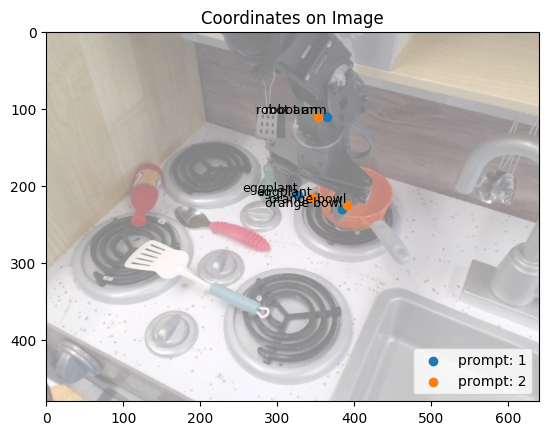



Multiple runs:
Run: 1 - Output:  (eggplant, (47.1, 42.5)), (robot arm, (56.0, 17.2)), (orange bowl, (60.5, 47.2))
Run: 2 - Output:  (eggplant, (46.5, 42.1)), (robot arm, (55.2, 25.3)), (orange bowl, (61.4, 47.7)), (burners, (60.8, 56.2), (61.6, 76.2))
Run: 3 - Output:  (eggplant, (51.3, 42.4)), (robot arm, (56.1, 24.1)), (orange bowl, (61.5, 46.0)), (burners, (61.5, 55.5), (52.5, 73.6))


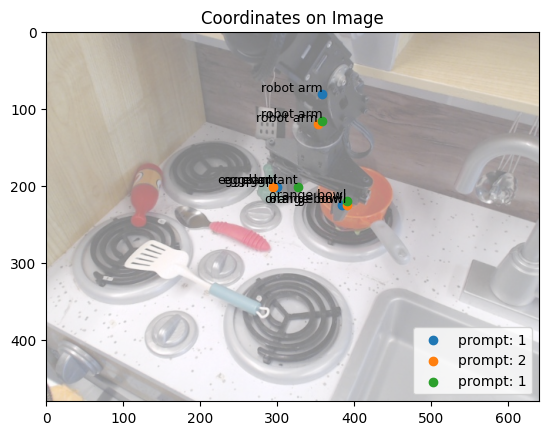



Testing different Temperatures:
Temperature: 0.3 - Output:  (eggplant, (57.0, 49.8)), (orange bowl, (59.4, 48.7)), (robot arm, (57.0, 27.0))
Temperature: 0.4 - Output:  (eggplant, (53.2, 44.0)), (robot arm, (56.1, 21.4)), (orange bowl, (61.0, 45.6))
Temperature: 0.6 - Output:  (eggplant, (53.8, 45.9)), (orange bowl, (58.6, 49.6)), (robot arm, (56.9, 18.2))
Temperature: 0.7 - Output:  (eggplant, (47.8, 41.3)), (orange bowl, (60.4, 48.6)), (robot arm, (57.1, 22.7))


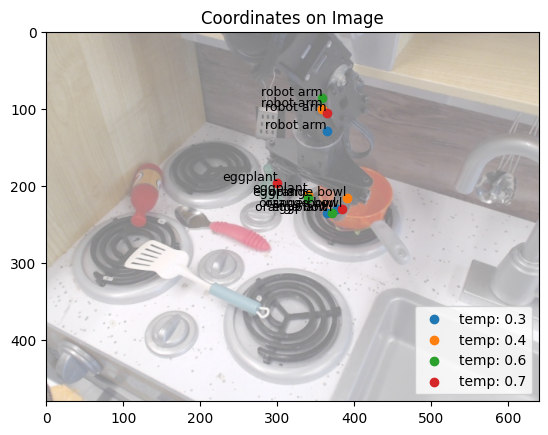



Task: 4
Task: move arch on the table and place it on top of another arch
confidence: 0.4

Different Prompts:
Prompt: 1 - Output:  (robot arm, (50, 50)), (arch, (40, 60)), (arch, (60, 70))
Prompt: 2 - Output:  (arch, (59.4, 89.5)), (arch, (69.4, 78.0))


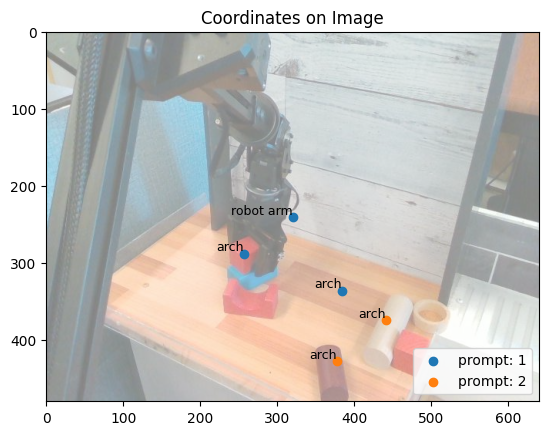



Multiple runs:
Run: 1 - Output:  (robot arm, (50, 50)), (arch, (40, 60)), (arch, (60, 70))
Run: 2 - Output:  (robot arm, (50, 50)), (arch, (40, 60)), (arch, (60, 70))
Run: 3 - Output:  (robot arm, (50, 50)), (arch, (40, 60)), (arch, (60, 70))


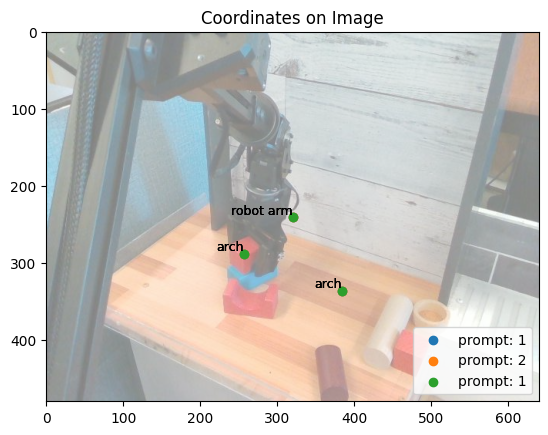



Testing different Temperatures:
Temperature: 0.3 - Output:  (wooden arch, (41.1, 73.0)), (wooden arch, (42.2, 63.0)), (wooden arch, (43.1, 58.9)), (wooden arch, (43.1, 76.0)), (wooden arch, (68.2, 82.6))
Temperature: 0.4 - Output:  (red arch, (44.5, 74.1)), (blue arch, (40.4, 62.9)), (wooden arch, (70.5, 81.0))
Temperature: 0.6 - Output:  (blue arch, (40.1, 69.6)), (red arch, (43.7, 73.0)), (robot arm, (42.2, 48.9))
Temperature: 0.7 - Output:  (arch, (40.3, 73.9)), (arch, (37.2, 66.3)), (robot arm, (38.4, 47.3))


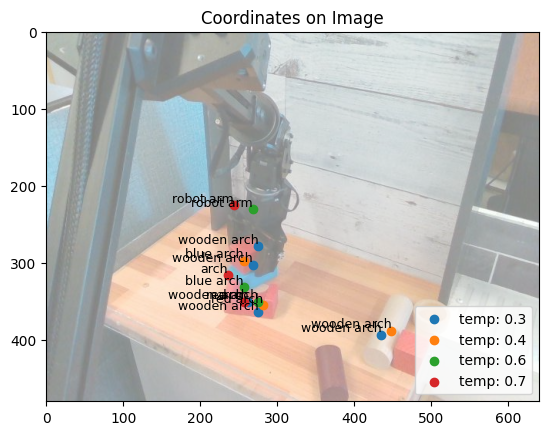



Task: 5
Task: take sushi out of pan

Different Prompts:
Prompt: 1 - Output:  (pan, (33.2, 25.4)), (sushi, (31.5, 23.0)), (robot arm, (60.0, 38.8))
Prompt: 2 - Output:  (pan, (33.8, 26.9)), (sushi, (31.6, 22.6)), (robot arm, (57.1, 36.1))


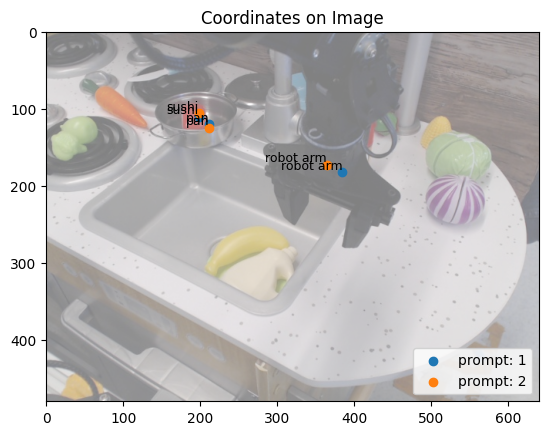



Multiple runs:
Run: 1 - Output:  (pan, (34.0, 26.3)), (sushi, (31.1, 22.6)), (robot arm, (59.9, 38.7))
Run: 2 - Output:  (pan, (40.4, 27.0)), (sushi, (31.5, 22.8)), (robot arm, (59.8, 36.5))
Run: 3 - Output:  (pan, (34.1, 26.3)), (sushi, (31.8, 22.5)), (robot arm, (59.9, 25.8))


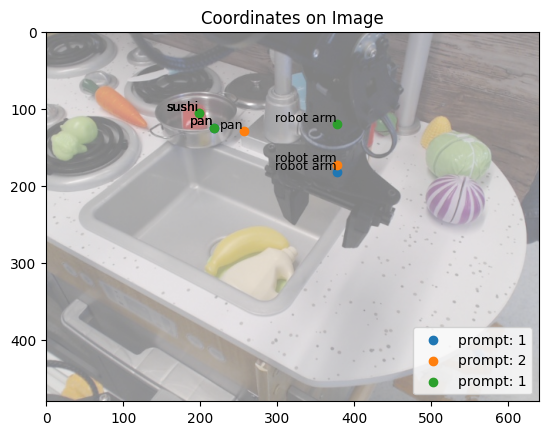



Testing different Temperatures:
Temperature: 0.3 - Output:  (pan, (31.5, 25.0)), (sushi, (32.1, 22.4)), (robot arm, (56.9, 38.6))
Temperature: 0.4 - Output:  (sushi pan, (34.5, 25.6)), (sushi, (31.6, 22.1)), (robot arm, (59.2, 35.5))
Temperature: 0.6 - Output:  (carrot, (16.2, 19.9)), (sushi pan, (31.8, 24.6)), (banana, (41.7, 56.5)), (milk carton, (45.2, 65.8)), (robot arm, (61.9, 20.0))
Temperature: 0.7 - Output:  (sushi pan, (37.4, 26.7)), (sushi, (33.5, 23.3)), (robot arm, (55.9, 21.6))


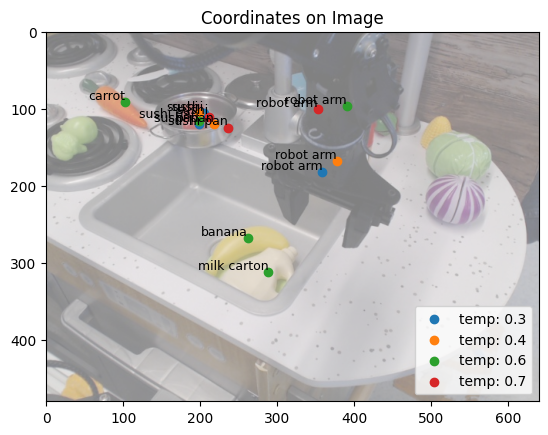



Task: 6
Task: pick up glass cup

Different Prompts:
Prompt: 1 - Output:  (glass cup, (38.9, 60.1)), (robot arm, (57.0, 13.2)), (dishwasher rack, (50.2, 40.6)), (white cup, (70.6, 28.0)), (white cup, (77.4, 48.1))
Prompt: 2 - Output:  (glass cup, (42.4, 59.8)), (robot arm, (55.6, 15.2))


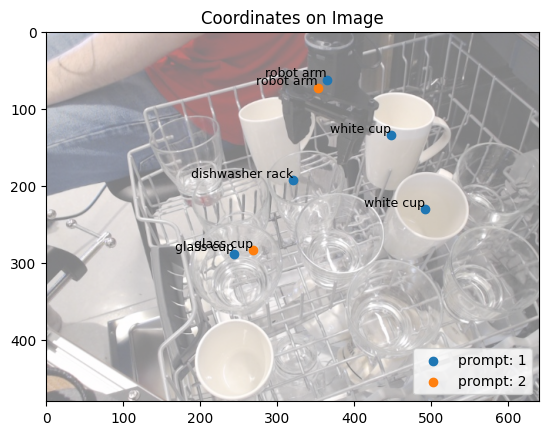



Multiple runs:
Run: 1 - Output:  (glass cup, (36.7, 64.2)), (robot arm, (57.6, 15.9)), (dishwasher rack, (50.0, 50.0)), (white cup, (71.3, 29.0))
Run: 2 - Output:  (glass cup, (38.5, 63.4)), (robot arm, (57.1, 13.5)), (dishwasher rack, (50.0, 48.0)), (white cup, (72.2, 27.5)), (white cup, (77.7, 46.6))
Run: 3 - Output:  (glass cup, (41.9, 60.3)), (robot arm, (56.5, 13.6)), (dishwasher rack, (53.8, 40.0)), (white cup, (72.3, 28.2))


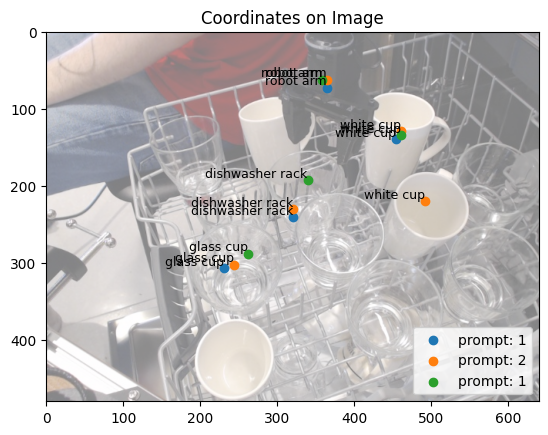



Testing different Temperatures:
Temperature: 0.3 - Output:  (glass cup, (41.0, 62.3)), (robot arm, (57.1, 10.6))
Temperature: 0.4 - Output:  (glass cup, (50, 50)), (dishwasher, (80, 60)), (robot arm, (55, 15))
Temperature: 0.6 - Output:  (glass cup, (53.2, 38.5)), (robot arm, (54.0, 15.2)), (glass cup, (73.5, 74.4))
Temperature: 0.7 - Output:  (goblet, (44.7, 62.6)), (robot arm, (55.5, 14.5))


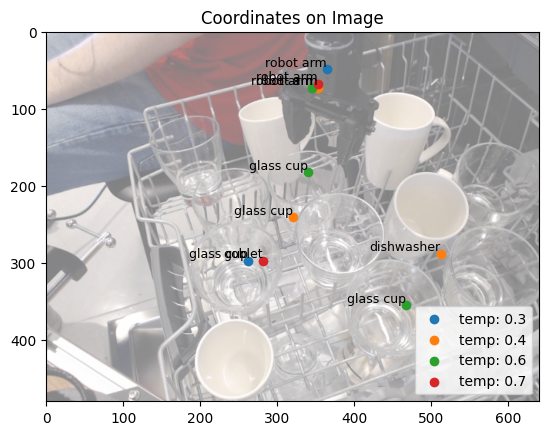



Task: 7
Task: open low fridge

Different Prompts:
Prompt: 1 - Output:  (low fridge, (54.2, 52.2)), (drawer, (54.2, 52.2)), (robot arm, (10.4, 31.0)), (floor, (26.7, 81.6)), (wall, (11.2, 11.0))
Prompt: 2 - Output:  (low fridge, (56.1, 50.4)), (drawer, (84.2, 69.3)), (robot arm, (10.6, 30.6))


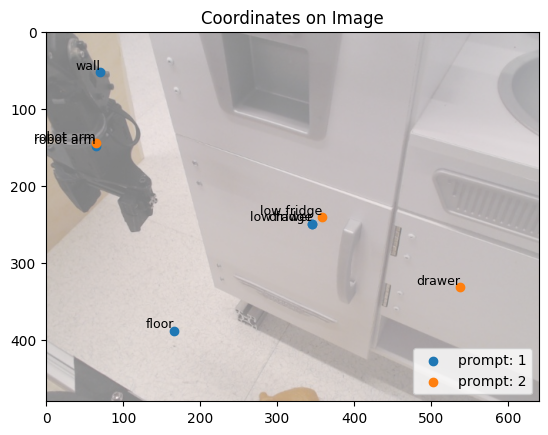



Multiple runs:
Run: 1 - Output:  (low fridge, (51.6, 48.0)), (robot arm, (11.1, 32.4)), (drawer, (84.2, 66.3)), (drawer handle, (61.1, 56.6)), (shelf, (46.5, 15.6))
Run: 2 - Output:  (low fridge, (56.0, 51.1)), (drawer, (84.0, 67.5)), (robot arm, (10.0, 27.0))
Run: 3 - Output:  (low fridge, (55.1, 49.5)), (robot arm, (10.3, 34.1)), (drawer, (85.0, 68.0)), (drawer handle, (61.8, 57.3)), (shelf, (46.5, 15.1))


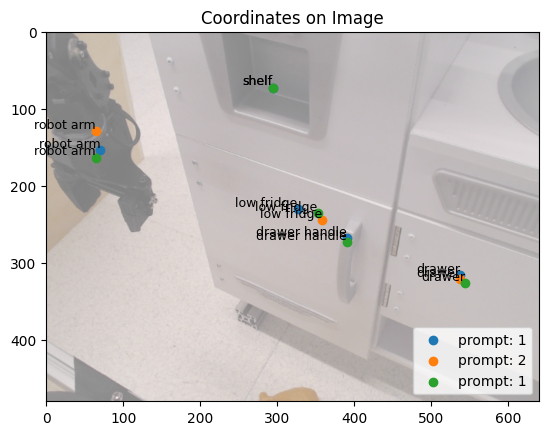



Testing different Temperatures:
Temperature: 0.3 - Output:  (fridge door, (54.5, 51.2)), (robot arm, (10.1, 30.7)), (drawer, (85.7, 65.6))
Temperature: 0.4 - Output:  (Low fridge, (64.7, 43.8)), (Fridge drawer, (65.7, 72.4)), (Robot arm, (11.1, 33.8))
Temperature: 0.6 - Output:  (Low fridge, (58.7, 54.7)), (White cabinet, (63.1, 35.9)), (Robot arm, (11.5, 32.4)), (Floor, (23.7, 68.8)), (Brown object, (53.1, 98.8))
Temperature: 0.7 - Output:  (low fridge, (47.8, 49.8)), (drawer, (48.8, 72.9)), (handle, (61.2, 54.3)), (water dispenser, (47.0, 15.7)), (robot arm, (9.4, 27.7))


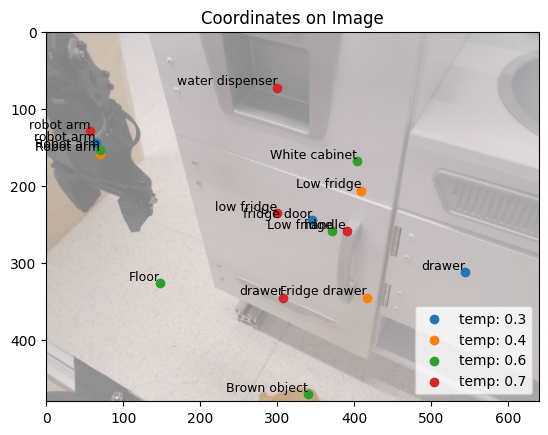



Task: 8
Task: Place the pot to the right of the blue fork.
Move silver pot to lower right corner of the table.

Different Prompts:
Prompt: 1 - Output:  (blue fork, (27.9, 59.3)), (silver pot, (46.0, 32.2)), (pot holder, (39.1, 38.1)), (table, (59.3, 60.5)), (robot arm, (92.9, 50.6))
Prompt: 2 - Output:  (blue fork, (35, 61)), (silver pot, (43, 34)), (can, (20, 43)), (wooden table, (56, 62)), (white wall, (68, 18)), (robot arm, (50, 50))


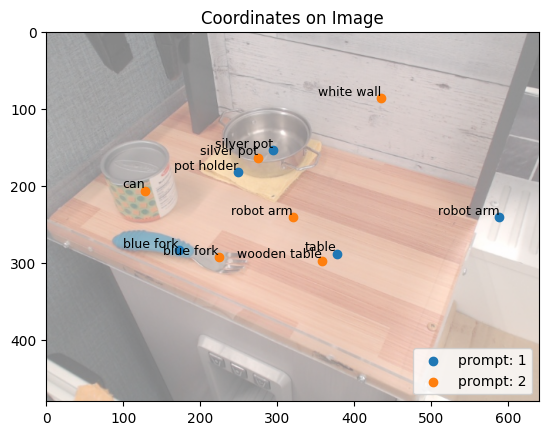



Multiple runs:
Run: 1 - Output:  (blue fork, (31.4, 60.4)), (silver pot, (45.0, 31.6)), (pot holder, (42.3, 39.0)), (robot arm, (13.7, 5.3))
Run: 2 - Output:  (blue fork, (27.9, 60.2)), (silver pot, (45.5, 32.0)), (pot holder, (41.5, 39.8)), (table, (58.4, 59.2)), (robot arm, (90.5, 50.8))
Run: 3 - Output:  (blue fork, (30, 59)), (silver pot, (45, 32)), (wooden table, (60, 50)), (can, (20, 41)), (robot arm, (90, 70))


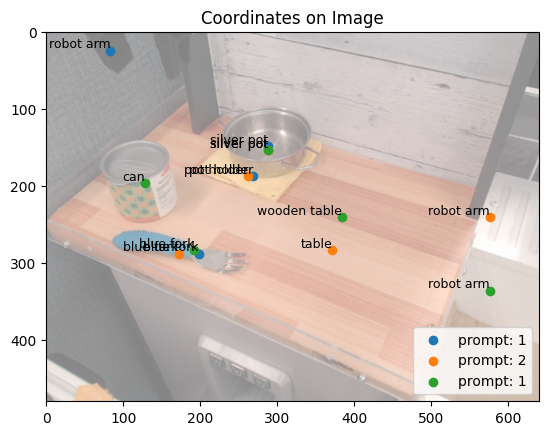



Testing different Temperatures:
Temperature: 0.3 - Output:  (blue fork, (34.9, 60.1)), (silver pot, (44.0, 30.1)), (wooden table, (56.5, 58.5)), (can, (20.4, 43.0)), (wooden wall, (67.0, 18.4))
Temperature: 0.4 - Output:  (pot, (50, 30)), (blue fork, (30, 59)), (can, (20, 42))
Temperature: 0.6 - Output:  (pot, (51, 33)), (fork, (26, 56)), (can, (21, 42))
Temperature: 0.7 - Output:  (blue fork, (20, 59)), (silver pot, (41, 29)), (pot holder, (36, 39)), (can, (20, 41)), (robot arm, (50, 50))


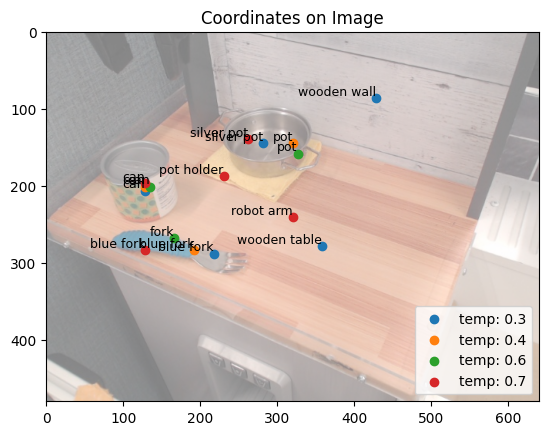

In [35]:
#tasks, images = extract_tasks_and_images("./data")
tasks, images = extract_tasks_and_images("./data2")

for i in range(len(tasks)):
    print(f"Task: {i + 1}")
    image = images[i]
    task = tasks[i]
    labels = []
    
    
    objects_of_all_prompts = []
    print(f"Task: {task}")
    print("Different Prompts:")
    for j in range(len(prompts)):
        labels.append(f"prompt: {j + 1}")
        prompt = prompts[j]
        
        output = do_inference_on_image(image, task, prompt)
        objects_of_all_prompts.append(extract_objects_from_model_output(output))
    
        print(f"Prompt: {j + 1} - Output: {output}")

    
    visualize_points_on_image(image, labels, objects_of_all_prompts)
    print("")
    print("")


    objects_of_all_prompts = []
    print("Multiple runs:")
    for j in range(3):
        labels.append(f"prompt: {j + 1}")
        
        output = do_inference_on_image(image, task, prompts[0])
        objects_of_all_prompts.append(extract_objects_from_model_output(output))
    
        print(f"Run: {j + 1} - Output: {output}")

    
    visualize_points_on_image(image, labels, objects_of_all_prompts)
    print("")
    print("")

    #"""
    labels = []
    objects_of_all_prompts = []
    print("Testing different Temperatures:")
    for j in range(len(temperatures)):
        temp = temperatures[j]
        labels.append(f"temp: {temp}")
        
        output = do_inference_on_image(image, task, prompts[1], temp)
        objects_of_all_prompts.append(extract_objects_from_model_output(output))
    
        print(f"Temperature: {temp} - Output: {output}")

    visualize_points_on_image(image, labels, objects_of_all_prompts)
    print("")
    print("")
    #"""

# Ab hier alter code

In [ ]:
# process the image and text
inputs = processor.process(
    images=[Image.open("./Images/im_4.jpg")],
    text="You are the robot in the picture. Your task is to: put cup from counter or drying rack into sink. Find the relevant objects for that in the picture and only output the coordinates of these objects."   
)

In [ ]:
# move inputs to the correct device and make a batch of size 1
inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}
print(model.device)

In [ ]:
# generate output; maximum 200 new tokens; stop generation when <|endoftext|> is generated
with torch.autocast(device_type="cuda", enabled=True, dtype=torch.bfloat16):
  output = model.generate_from_batch(
      inputs,
      GenerationConfig(max_new_tokens=200, stop_strings="<|endoftext|>"),
      tokenizer=processor.tokenizer
  )

In [ ]:
# only get generated tokens; decode them to text
generated_tokens = output[0,inputs['input_ids'].size(1):]
generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

In [ ]:
print(generated_text)

In [ ]:
inputs = processor.process(
    images=[Image.open("./Images/im_6.jpg")],
    text="You are the robot in the picture. Your task is to: put cup from counter or drying rack into sink. Find the relevant objects for that in the picture and output the coordinates of these objects."   
)

# move inputs to the correct device and make a batch of size 1
inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}
print(model.device)

In [ ]:
# generate output; maximum 200 new tokens; stop generation when <|endoftext|> is generated
with torch.autocast(device_type="cuda", enabled=True, dtype=torch.bfloat16):
  output = model.generate_from_batch(
      inputs,
      GenerationConfig(max_new_tokens=200, stop_strings="<|endoftext|>"),
      tokenizer=processor.tokenizer
  )

generated_tokens = output[0,inputs['input_ids'].size(1):]
generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)
print(generated_text)